First install the repo and requirements.

In [ ]:
%pip --quiet install git+https://github.com/wilson-labs/cola.git

# Accessing Lower Level Algorithms (CG, Lanczos, Arnoldi, etc)

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

import time
import torch
import cola
import jax.numpy as jnp

Let's construct a simple example matrix with a rapidly decaying spectrum, such as an RBF kernel.

In [36]:
x = torch.linspace(-1,1,3000)
C = cola.lazify(torch.exp(-(x[None]-x[:,None])**2/2))
C = C+1e-4*cola.eigmax(C,tol=1e-2)*cola.ops.I_like(C)

We can run CG, GMRES to perform solves, or lanczos and arnoldi for decompositions to compute $f(A)v$ for a vector $v$ or for estimating the extremal eigenvalues.

In [37]:
y = torch.randn(C.shape[-1])
sol, info = cola.algorithms.cg(C, y, tol=1e-4, pbar=True)
sol1, info1 = cola.algorithms.gmres(C, y, tol=1e-4, pbar=True)
Q1,T,info2 = cola.algorithms.lanczos(C, pbar=True, tol=1e-4, max_iters=1000)
Q2,H,info3 = cola.algorithms.arnoldi(C, pbar=True, tol=1e-4, max_iters=1000)


Running body_fun:   0%|          | 0/100 [00:00<?, ?it/s]

Running body_fun:   0%|          | 0/100 [00:00<?, ?it/s]

Running body_fun:   0%|          | 0/100 [00:00<?, ?it/s]

Running body_fun:   0%|          | 0/100 [00:00<?, ?it/s]

Information on the convergence criteria, number of iterations used, and the time per iteration is returned in the info dictionary. We can also use `pbar=True` to track the convergence with a tqdm progressbar.

In [39]:
print(info)

{'iterations': 13, 'errors': array([1.56363926e+01, 4.05478191e+00, 1.60241783e-01, 1.88410982e-01,
       3.71066853e-02, 2.52811611e-01, 2.25780299e-03, 2.09524352e-02,
       8.54305644e-03, 1.05140622e-04, 9.50152207e-06, 9.50152207e-06]), 'iteration_time': 0.004091776334322416}


Let's plot the convergence criteria for these different algorithms:

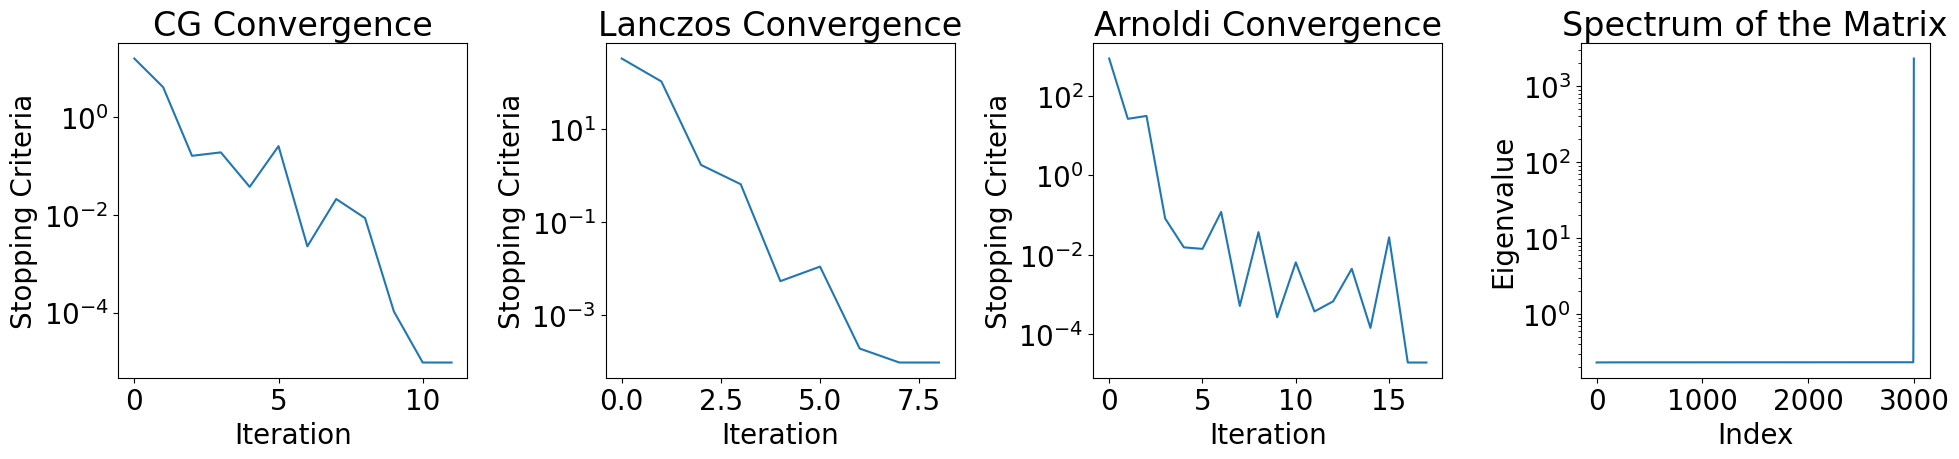

In [40]:
eigs = cola.eig(cola.SelfAdjoint(C),pbar=True, method='dense')[0]

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20
algorithms = [('CG', info), ('Lanczos', info2), ('Arnoldi', info3)]
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, (name, info) in enumerate(algorithms):
    axs[i].plot(info['errors'])
    axs[i].set_yscale('log')
    axs[i].set_title(f'{name} Convergence')
    axs[i].set_xlabel('Iteration')
    axs[i].set_ylabel('Stopping Criteria')

axs[3].plot(eigs)
axs[3].set_yscale('log')
axs[3].set_title('Spectrum of the Matrix')
axs[3].set_xlabel('Index')
axs[3].set_ylabel('Eigenvalue')

plt.tight_layout()
plt.show()

For CG, the residual $\|Ax-b\|$ is the stopping criteria, whereas for Lanczos and Arnoldi it is diagonal entries in the Tridiagonal and Upper Hessenberg matrices respectively.

One tricky thing is that if you `jit` the algorithm or a function containing the algorithm, then the info dict will no longer be populated as jitted methods must always return arrays of the same shape. (though the progress bar will still be updated)

In [44]:
import jax

C_jax = cola.lazify(jnp.array(C.to_dense()))
y_jax = jnp.array(y)

def mycg(C,y):
    return cola.algorithms.cg(C,y,tol=1e-4,pbar=True)
solj, infoj = jax.jit(mycg)(C_jax, y_jax)

Running body_fun:   0%|          | 0/100 [00:00<?,?it/s]

In [45]:
print(infoj)

{}


# Gaussian Processes from scratch

Loading the Data
First, we need to load the dataset that we'll use for training and testing the GP model. Here, we're using the UCI Machine Learning Repository's "bike" dataset, and using only the last feature so that the predictions can be easily visualized.

In [1]:
!wget -O bike.mat "https://www.andpotap.com/static/bike.mat"

--2023-08-01 20:03:34--  https://www.andpotap.com/static/bike.mat
Resolving www.andpotap.com (www.andpotap.com)... 69.164.216.245
Connecting to www.andpotap.com (www.andpotap.com)|69.164.216.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 434829 (425K) [application/octet-stream]
Saving to: ‘bike.mat’

bike.mat            100%[===================>] 424.64K  --.-KB/s    in 0.04s   

2023-08-01 20:03:34 (10.5 MB/s) - ‘bike.mat’ saved [434829/434829]



In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [3]:
from jax import numpy as jnp
import os
import numpy as np
from math import floor
from scipy.io import loadmat
import cola


def load_uci_data(data_dir, dataset, train_p=0.75, test_p=0.15):
    file_path = os.path.join(data_dir, dataset + '.mat')
    data = np.array(loadmat(file_path)['data'])
    X = data[:, -2:-1]
    y = data[:, -1]

    X = X - X.min(0)[None]
    X = 2.0 * (X / X.max(0)[None]) - 1.0
    y -= y.mean()
    y /= y.std()


    train_n = int(floor(train_p * X.shape[0]))
    return X[:train_n], y[:train_n], X[train_n:], y[train_n:]



train_x, train_y, test_x, test_y = load_uci_data(data_dir="./", dataset="bike")

dtype = jnp.float32
train_x  = train_x[:3000]
train_y  = train_y[:3000]

In [4]:
def rbf(ls, uscale):
    def f(x, y):
        # (n, d) and (m, d) -> (n, m)
        inner = x@y.T
        sqdist = (x**2).sum(1).reshape(-1, 1) + (y**2).sum(1) - 2*inner
        return uscale*jnp.exp(-sqdist / ls**2)
    return f

For a Gaussian Process, the predictive distribution of the function values at test inputs $X_*$
  given the training inputs 
$X$ and training targets 
$y$ is given by:

$$f_* | X, y, X_* \sim \mathcal{N}(\mu_*, \Sigma_*)$$

where:

$$\mu_* = K(X_*, X)[K(X, X) + \sigma^2_n I]^{-1}y$$

$$\Sigma_* = K(X_*, X_*) - K(X_*, X)[K(X, X) + \sigma^2_n I]^{-1}K(X, X_*)$$

Here, $K$ is the RBF kernel, $X$ are the training inputs, $y$ are the training targets, $X_*$ are the test inputs, and $\sigma^2_n$ is the noise variance.

We will get the variances from the diagonal of the predictive covariance.

In [5]:
ls, uscale, noise = .2, .5, 1e-3

def predicted_mean_std(ls,uscale,noise):
    kernel = rbf(ls=ls, uscale=uscale)
    Kxx= cola.ops.Dense(kernel(train_x, train_x))
    Kzx = cola.ops.Dense(kernel(test_x, train_x))
    Kzz = cola.ops.Dense(kernel(test_x, test_x))
    K = cola.PSD(Kxx + noise * cola.ops.I_like(Kxx))
    invK = cola.inv(K)
    mu = Kzx@invK@train_y
    Sigma = Kzz - Kzx@invK@Kzx.T
    std = jnp.sqrt(cola.diag(Sigma,method='exact'))
    return mu,std

### Visualization
Next, we visualize the GP's prediction with the initial hyperparameters:

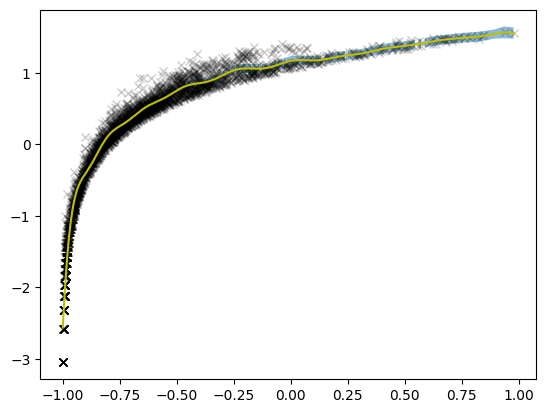

In [6]:
import matplotlib.pyplot as plt
mu, std = predicted_mean_std(ls,uscale,noise)
pstd = np.sqrt(std**2+noise) # prediction interval std
order = np.argsort(test_x.reshape(-1))
plt.plot(train_x.reshape(-1), train_y, 'kx', alpha=.2)
plt.plot(test_x[order].reshape(-1), mu[order], 'y')
plt.fill_between(test_x[order].reshape(-1), (mu - 2*pstd)[order], (mu + 2*pstd)[order], alpha=.5, interpolate=True)

As you can see, we have chosen the noise value too small for the data.
But lets fix that by optimizing these parameters using the marginal log likelihood

## Hyperparameter Optimization
Often, the initial hyperparameter values may not fit the data well. We can optimize these parameters using the marginal log-likelihood:

$$
\text{NLL} = \frac{1}{2} y^T (K + \sigma^2_n I)^{-1} y + \frac{1}{2} \log |K + \sigma^2_n I| + \frac{n}{2} \log 2\pi
$$

Here:

- $y$ is the vector of target values.
- $K$ is the kernel matrix computed using the RBF kernel between the training inputs.
- $\sigma^2_n$ is the noise variance.
- $I$ is the identity matrix.
- $n$ is the number of training examples.

In [7]:
# compute the MLL
y = train_y
def NLL(params, key):
    ls,uscale,noise = params
    kernel = rbf(ls, uscale)
    Kxx= cola.ops.Dense(kernel(train_x, train_x))
    K = cola.PSD(Kxx + noise * cola.ops.I_like(Kxx))
    #K = cola.decompositions.cholesky_decomposed(K)
    invK = cola.inv(K)
    minus2MLL =y.T@(invK@y)+cola.logdet(K,key=key)+jnp.log(2*jnp.pi)*y.shape[0]
    return minus2MLL/(2*y.shape[0])

Using optax and jax, we create a training loop to optimize the hyperparameters:

In [8]:
import optax
import jax
# create the training loop
opt = optax.adam(3e-3)

@jax.jit
def step(params,opt_state, key):
    loss, grads = jax.value_and_grad(NLL)(params, key)
    key = jax.random.split(key)[0]
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, key

params = list(map(jnp.array,(ls,uscale,noise)))
opt_state = opt.init(params)
key = jax.random.PRNGKey(0)
for i in range(10):
    params,opt_state,loss,key = step(params,opt_state,key)
    print(f"loss: {loss.item():.3f}")

loss: 6.910
loss: 0.733
loss: 0.100
loss: -0.128
loss: -0.239
loss: -0.311
loss: -0.352
loss: -0.383
loss: -0.404
loss: -0.420


Now we have a new lengthscale, uncertainty scale and noise level.

In [9]:
ls, uscale, noise = params
print(f"ls = {ls:.2f}, uscale = {uscale:.2f}, noise = {noise:.2f}")

ls = 0.18, uscale = 0.52, noise = 0.01


### Final Visualization
Finally, we visualize the GP's prediction with the optimized hyperparameters. The new plot shows a better fit to the data:

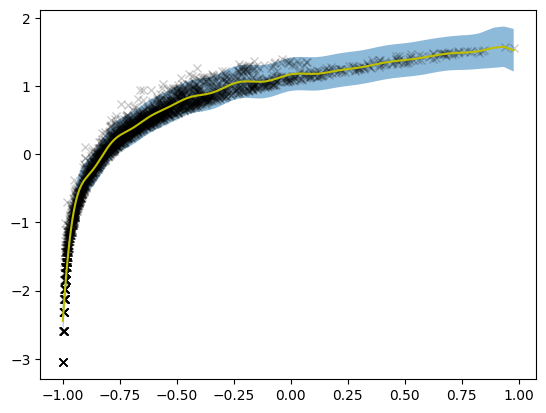

In [10]:
import matplotlib.pyplot as plt

mu, std = predicted_mean_std(ls,uscale,noise)
pstd = np.sqrt(std**2+noise) # prediction interval std
order = np.argsort(test_x.reshape(-1))
plt.plot(train_x.reshape(-1), train_y, 'kx', alpha=.2)
plt.plot(test_x[order].reshape(-1), mu[order], 'y')
plt.fill_between(test_x[order].reshape(-1), (mu - 2*pstd)[order], (mu + 2*pstd)[order], alpha=.5, interpolate=True)

# Spectral Clustering

In this application, we'll show how `CoLA` can be used to perform Spectral Clustering. This application allows us to showcase our `Sparse` operator.

In terms of the data, we will use the arXiv paper citation network of High Energy Physics. This is a directed graph showing the papers cited for each paper in the dataset. As in this case we will consider two papers to be related if at least one cited the other, then it will suffice to use an undirected graph. 

The following command would download the data in case it is not on the `data` folder under the user's `HOME` directory.

In [1]:
![ ! -f "$HOME/data/cit-HepPh.txt" ] && wget -P ~/data https://www.andpotap.com/static/cit-HepPh.txt

In [2]:
import os
import warnings

warnings.filterwarnings('ignore')
input_path = os.path.join(os.environ['HOME'], "data/cit-HepPh.txt")

To pre-process the data we will use the following code:

In [3]:
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np


def load_graph_data(filepath, dtype, xnp, num_edges=-1):
    df = pd.read_csv(filepath, skiprows=4, delimiter="\t", header=None, names=["to", "from"])
    df = df[:num_edges]
    df2 = pd.read_csv(filepath, skiprows=4, delimiter="\t", header=None, names=["from", "to"])
    df2 = df2[:num_edges]
    df_undir = pd.concat((df, df2), axis=0)
    df_undir = df_undir.drop_duplicates()
    id_map = map_nodes_to_id(df_undir["from"].unique())
    N = len(id_map)
    print(f"Found {N:,d} nodes")
    for col in ["from", "to"]:
        df_undir[col] = df_undir[col].map(id_map)
    data = np.ones(shape=len(df_undir))
    row, col = np.array(df_undir["to"]), np.array(df_undir["from"])
    sparse_matrix = csr_matrix((data, (row, col)), shape=(N, N))
    out = transform_to_csr(sparse_matrix, xnp, dtype)
    data, col_ind, rowptr, shape = out
    return data, col_ind, rowptr, shape


def transform_to_csr(sparse_matrix, xnp, dtype):
    data = xnp.array(sparse_matrix.data, dtype=dtype, device=None)
    indices = xnp.array(sparse_matrix.indices, dtype=xnp.int64, device=None)
    indptr = xnp.array(sparse_matrix.indptr, dtype=xnp.int64, device=None)
    return data, indices, indptr, sparse_matrix.shape


def map_nodes_to_id(nodes):
    out = {}
    for idx in range(len(nodes)):
        out[int(nodes[idx])] = idx
    return out

The function `load_graph_data` creates the column indices and row pointers needed for the sparse [CSR format](https://en.wikipedia.org/wiki/Sparse_matrix). Now, we can load the data and create our `Sparse` adjacency matrix as follows

In [4]:
import torch
import cola
from cola.backends import torch_fns as xnp

num_edges = -1
dtype = torch.float64
data, col_ind, rowptr, shape = load_graph_data(input_path, dtype, xnp, num_edges)
Ad = cola.ops.Sparse(data, col_ind, rowptr, shape)

Found 34,545 nodes


Given the adjacency matrix, we can now create the normalized Laplacian defined as $L=I - D^{-1/2} A D^{-1/2}$, where $D$ is the diagonal matrix that contains the degree of each node, $A$ is the adjacency matrix and $I$ is the identity. We can create the Laplacian operator really easily in `CoLA` as

In [5]:
Deg = cola.ops.Diagonal(Ad @ torch.ones((Ad.shape[0], ), dtype=dtype))
Id = cola.ops.I_like(Deg)
Lap = Id - cola.inv(cola.sqrt(Deg)) @ Ad @ cola.inv(cola.sqrt(Deg))
Lap = cola.SelfAdjoint(Lap)
print(f"Size of the Laplacian: {Lap.shape}")

Size of the Laplacian: (34545, 34545)


Where I added the `SelfAdjoint` annotation at the end to ensure that `CoLA` dispatches algorithms for this type of symmetric operator. Spectral Clustering requires that we compute the eigenvectors of the smallest eigenvalues and use those eigenvectors as an embedding of our data. Once we do this, we can then use k-means to cluster points nearby as those points are related to cliques in the original graph.

In [6]:
from sklearn.cluster import KMeans

embedding_size, n_clusters = 8, 8
eigvals, eigvecs = cola.eig(Lap, k=Lap.shape[0], which="LM", alg=cola.Lanczos(max_iters=300))
x_emb = eigvecs[:, :embedding_size].to_dense()
kmeans = KMeans(n_clusters=n_clusters).fit(x_emb)

In [7]:
kmeans.labels_[100:200]

array([0, 0, 0, 0, 0, 0, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 7, 0, 0, 0,
       0, 0, 7, 7, 7, 0, 7, 0, 0, 7, 7, 0, 0, 0, 7, 0, 0, 7, 7, 7, 7, 0,
       0, 7, 0, 7, 7, 0, 7, 7, 7, 0, 0, 0, 7, 7, 0, 0, 0, 0, 7, 7, 7, 7,
       7, 7, 0, 0, 7, 7, 0, 0, 7, 7, 7, 0, 0, 0, 0, 7, 0, 7, 7, 7, 7, 7,
       0, 0, 7, 7, 0, 0, 0, 7, 0, 7, 0, 0], dtype=int32)

# Boundary Value PDEs

In this example we will show how CoLA can be used to solve linear and nonlinear boundary value PDEs.

## Laplace Equation $\Delta u = 0$

For this example we will solve the Laplace equation on an irregularly shaped domain with given boundary conditions using a finite difference discretization.

First lets create a 1000 x 1000 point coordinate mesh.

In [1]:
import numpy as np
import jax.numpy as jnp
import scipy
import jax


N=1000
ndims = 2

xgrid = jnp.linspace(-1,1,N)
xygrid = jnp.stack(jnp.meshgrid(*(ndims*[xgrid])),axis=-1)
dx = xgrid[1]-xgrid[0]
x,y = xygrid.transpose((2,0,1))

CUDA backend failed to initialize: Found CUDA version 12000, but JAX was built against version 12020, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


With the mesh, lets define the geometry of the PDE domain and boundary conditions. The domain need not be square as shown below. For boundary conditions, we will set them to be $B(x,y) = (x+y)\cos(2x)$ on the boundary of this domain.

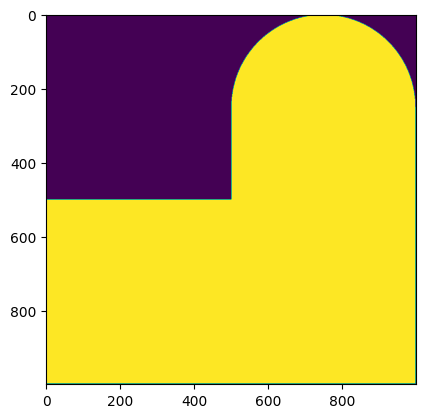

In [2]:
from scipy.signal import convolve2d
domain = (((x>0)|(y>0))&((y>-.5)|((x-.5)**2+(y+.5)**2<.5**2))) # chosen for example
# reduce the domain by one pixel leave space for the boundary conditions
domain &= ~(convolve2d((~domain).astype(np.float32),jnp.ones((3,3)),mode='same',fillvalue=1)>0)
domain_ids, = domain.reshape(-1).nonzero()

BCS = jnp.where(domain,jnp.zeros_like(x),(x+y)*jnp.cos(2*x))


import matplotlib.pyplot as plt
plt.imshow(domain)
plt.show()


Now we need to define the Laplacian $\Delta$ as it acts on this discretized domain. 
Supposing we have the two dimensional array $v[i,j]$ representing the values on the grid, we can use the centered difference stencil for second derivatives $\partial_x^2 v(x_i,y_j) = (v[i+1, j] - 2*v[i, j] + v[i-1, j])/h^2$ + O(h^3)$.

Equivalently, we can write this as a convolution $\partial_x^2 v(x_i,y_j) =(1/h^2) (\begin{bmatrix}1& -2 &1\end{bmatrix} * v)[i,j] + O(h^3)$ where $*$ is the discrete convolution. The discretized 2d Laplacian is therefore

$Lv = (\begin{bmatrix}1& -2 &1\end{bmatrix} * v + \begin{bmatrix} 1 \\ -2 \\ 1 \end{bmatrix} *v)/h^2$. 

From this matrix vector multiply, we can define the linear operator using CoLA.

In [4]:
import cola
from jax import vmap, jit

def laplacian(x):
    x = x.reshape(ndims*(N,)) # unflatten to an ndims-dimensional grid
    cderiv = lambda x: jax.scipy.signal.correlate(x,jnp.array([1.,-2,1.])/dx**2,mode='same')
    return sum([jnp.apply_along_axis(cderiv,i,x) for i in range(ndims)]).reshape(-1)

Lfull = cola.ops.LinearOperator(jnp.float32,shape=(N**ndims,N**ndims),matmat=jit(vmap(laplacian,-1,-1)))
Lfull = cola.PSD(Lfull)

Lfull is defined on the full $1000 \times 1000$ grid rather than our irregularly shaped domain. Restrict it to the domain, we just need to select the indices of the points inside the domain by slicing it, as you would a matrix.

In [5]:
L = Lfull[domain_ids,domain_ids]

Since this would ignore the boundary conditions, we can simply add them in on the right hand side.

In [6]:
RHS = -(Lfull@BCS.reshape(-1))[domain_ids]

Finally, let's solve the linear system represented by this discretized laplacian and the boundary conditions

$Lv = b$

and annotate that $L$ is a PSD operator to speed up the computation.

In [9]:
from cola import Auto
L = cola.PSD(L)
inv = cola.inv(L)
v  = inv@RHS

Though we need to invert a $1000000 \times 1000000$ sized matrix, the solution is produced very quickly because CoLA never forms the matrix explicitly, and we can visualize the solution below.

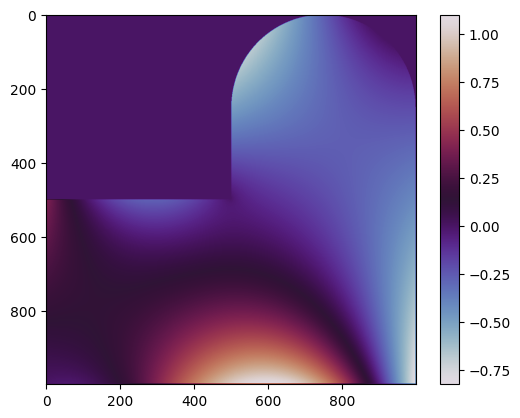

In [10]:
out_img = jnp.zeros(domain.shape)
out_img = out_img.at[domain].set(v)

plt.imshow(out_img,cmap='twilight')
plt.colorbar()
plt.show()

## Nonlinear BVP: Minimal Surface Equation

In this example we will consider solving the minimal surface equation, and example of a nonlinear boundary value PDE describing the shape of a soap bubble with a fixed boundary.
For the minimal surface, we would like to solve for the height $z$ of the surface at each point $(x,y)$ on the domain, and we make the assumption that the height is single valued.

The PDE is given by

$(1+z_x^2)z_{yy} - 2z_x z_y z_{xy} + (1+z_y^2)z_{xx}=0$

 where subscripts denote partial derivatives.
We will solve the PDE on the domain $[-1,1]^2$ with the boundary conditions

$z(x,\pm 1) = 1-x^2$ and $z(\pm 1, y) = 0$.

Before solving, first we will define the mesh and the nonlinear pde constraint.

In [11]:
N=50
xgrid = jnp.linspace(-1,1,N)
xygrid = jnp.stack(jnp.meshgrid(xgrid,xgrid),axis=-1)
dx = xgrid[1]-xgrid[0]

def pde_constraint(z):
    deriv = lambda x: jax.scipy.signal.correlate(x,jnp.array([-1/2,0,1/2])/dx,mode='same')
    deriv2 = lambda x: jax.scipy.signal.correlate(x,jnp.array([1.,-2,1.])/dx**2,mode='same')
    zx,zy = [jnp.apply_along_axis(deriv,i,z) for i in [0,1]]
    zxx,zyy = [jnp.apply_along_axis(deriv2,i,z) for i in [0,1]]
    zxy  = jnp.apply_along_axis(deriv,1,zx)
    return (1+zx**2)*zyy-2*zx*zy*zxy+(1+zy**2)*zxx

x,y = xygrid.transpose((2,0,1))
domain = (jnp.abs(x)<1)&(jnp.abs(y)<1)
boundary_vals = np.zeros_like(x)
boundary_vals[:,0] = 1-y[:,0]**2
boundary_vals[:,-1] = 1-y[:,-1]**2

@jit
def pde_constraint_on_domain(u):
    padded_domain = jnp.zeros(boundary_vals.shape)+boundary_vals
    padded_domain = padded_domain.at[domain].set(u.reshape(-1))
    padded_domain = pde_constraint(padded_domain)
    return padded_domain[domain].reshape(u.shape)

Now that we have defined the PDE constraint discretized on the domain,
we can now interpret the problem as finding the roots to a nonlinear function
$F(z)=0$ where $F$ is the discretized PDE constraint, and $z$ is a vector representing the heights at the different points on the domain.

To find the roots, we can employ Newtons method:

$z \gets z - J^{-1} F(z)$

where $J$ is the Jacobian of $z$.
While $J$ will be a large $N^2 \times N^2$ matrix, with CoLA we can perform this solve efficiently. For this we will use the CoLA [Jacobian](https://CoLA.readthedocs.io/en/latest/package/cola.ops.html#cola.ops.Jacobian) LinearOperator.

In [13]:
from cola.linalg import GMRES
# Newton Raphson iteration
tol = 3e-3

z = jnp.zeros_like(x[domain]).reshape(-1) # initial guess
err = np.inf
while err > tol:
    F = pde_constraint_on_domain(z)
    err = jnp.max(jnp.abs(F))
    J = cola.ops.Jacobian(pde_constraint_on_domain,z)
    z -= cola.inv(J, alg=GMRES(max_iters=100))@F
    print(f"PDE Error: {err:1.1e}")

PDE Error: 6.0e+02
PDE Error: 2.4e+02
PDE Error: 2.0e+02
PDE Error: 3.7e+01
PDE Error: 4.0e+00
PDE Error: 2.2e-02
PDE Error: 5.5e-04


Now let's visualize the results.

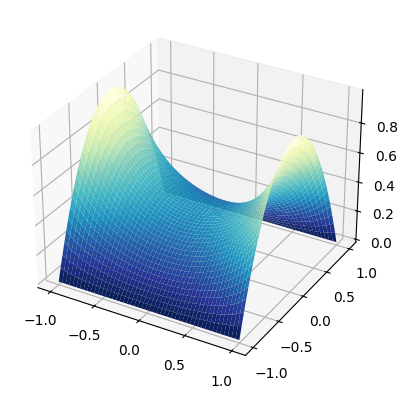

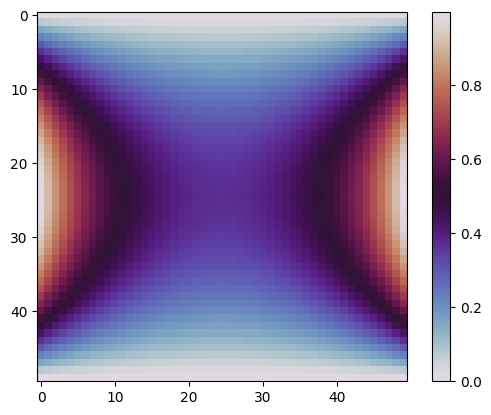

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
img = jnp.zeros(boundary_vals.shape)+boundary_vals
img = img.at[domain].set(z)
ax.plot_surface(x, y, img, cmap=plt.cm.YlGnBu_r)
plt.show()

plt.imshow(img,cmap='twilight')
plt.colorbar()
plt.show()

We see the minimal surface forms a familiar saddle shape, a solution of negative curvature like other solutions to the minimal surface equation.

# Diagonalizing a Hamiltonian (PDE eigenvalue problems)

## Solving the Schrodinger Equation for a 2d Harmonic oscillator

In this example, we will show how to use the CoLA library to solve for the eigenvalues and eigenfunctions of the Hamiltonian operator for a two-dimensional quantum harmonic oscillator. The Hamiltonian operator is defined as

H = -Δ/2 + V(x)

where Δ is the Laplacian operator and V(x) is the potential energy function. We will be using a discretized Laplacian on a square grid and a simple harmonic potential V(x) = x²/2.

To start, let's create a 1000 x 1000 point coordinate mesh:

In [1]:
import numpy as np
import jax.numpy as jnp
from jax import vmap, jit
import jax
import cola
from jax.config import config; config.update("jax_enable_x64", False)
jax.config.update('jax_platform_name', 'cpu')

N = 300
ndims = 2
grid = jnp.linspace(-30,30,N)
dx = grid[1]-grid[0]
xyz = jnp.stack(jnp.meshgrid(*(ndims * [grid])), axis=-1).reshape(-1, ndims)

Here, N is the number of points in each dimension, ndims is the number of dimensions, and grid represents the grid points from -30 to 30. dx represents the grid spacing, and xyz is an array of 2D points representing the coordinates of each point in the grid.

Next, we define the Laplacian operator. We use the same finite difference stencil as in the previous example to discretize the Laplacian.

In [2]:
def laplacian(x):
    x = x.reshape(ndims*(N,)) # unflatten to an ndims-dimensional grid
    cderiv = lambda x: jax.scipy.signal.correlate(x,jnp.array([1.,-2,1.])/dx**2,mode='same')
    return sum([jnp.apply_along_axis(cderiv,i,x) for i in range(ndims)]).reshape(-1)

L = cola.ops.LinearOperator(jnp.float32, shape=(N**ndims, N**ndims), matmat=jit(vmap(laplacian, -1, -1)))

The function laplacian calculates the second derivative along each dimension and sums them up. The result is reshaped to a 1D array and returned.

Next, we define the potential function V(x) as a diagonal operator:

In [3]:
def vfn(x):
    return (x * x).sum() / 2

V = cola.diag(vmap(vfn)(xyz).reshape(-1))

vfn calculates the potential energy for a given point in the grid. cola.diag creates a diagonal operator with the calculated potential energy values on the diagonal. vmap is a function from the JAX library that applies the function vfn to each point in xyz.

Next, we define the Hamiltonian operator and compute its eigenvalues and eigenvectors:

In [4]:
H = -L / 2 + V
energy_levels, eigenfunctions = cola.eig(cola.SelfAdjoint(H),max_iters=1000, tol=1e-4, method='iterative', pbar=True)
eigenfunctions = eigenfunctions.to_dense()

Running body_fun:   0%|          | 0/100 [00:00<?,?it/s]

/home/marc_f/cola/cola/jax_fns.py:248: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(arr, dtype=dtype)


The Hamiltonian operator H is defined as the sum of the kinetic energy operator (-Δ/2) and the potential energy operator (V). The cola.SelfAdjoint function is used to inform CoLA that H is a symmetric operator which makes the eigenvalue calculation more efficient.

We then plot the lowest several eigenvalues:

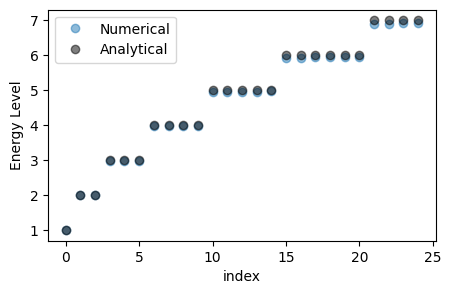

In [5]:
nm = np.stack(np.meshgrid(np.arange(10),np.arange(10)), axis=-1).reshape(-1, 2)
Enm = 1+nm[:,0]+nm[:,1]
nm = nm[Enm.argsort()]
Enm = np.sort(Enm)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, figsize=(5, 3))
axs.plot(energy_levels[:25], 'o',alpha=0.5, label="Numerical")
axs.plot(Enm[:25], 'o', color='k',alpha=0.5, label="Analytical")
plt.legend()
plt.xlabel("index")
plt.ylabel("Energy Level")
plt.show()

Each point represents an eigenvalue, which corresponds to an energy level of the quantum harmonic oscillator. Up to errors produced by the finite boundary (at [-30,30]) and discretization, we see the familiar $E_{nm} = (1/2+n)+(1/2+m)$ energy levels for the 2d oscillator.

Lastly, we visualize the corresponding eigenfunctions:

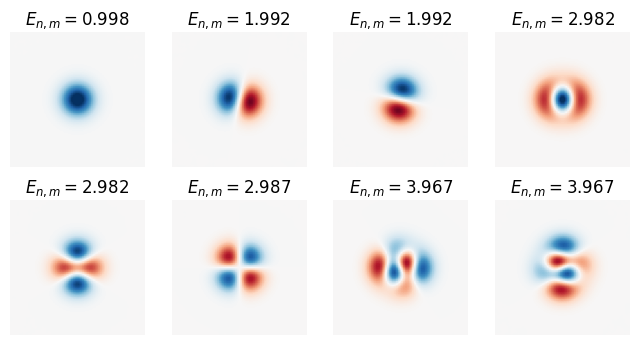

In [6]:
import numpy as np

fig, axs = plt.subplots(2, 4, figsize=(8, 4))
for i,ax in enumerate(axs.flatten()):
    l = 30
    ax.imshow(eigenfunctions[:, i].reshape(N,N)[N//2-l:N//2+l,N//2-l:N//2+l],
    extent=[grid[N//2-l],grid[N//2+l],grid[N//2+l],grid[N//2-l]],
    cmap='RdBu_r', vmin=-0.1, vmax=0.1)
    ax.set_title(r"$E_{{{}}} ={:.3f}$".format("n,m",energy_levels[i]))
    ax.axis('off')

Each subplot represents an eigenfunction, reshaped to 2D and displayed as an image. The eigenfunctions correspond to the wave functions of the quantum harmonic oscillator at different energy levels. The color represents the value of the wave function at each point in the grid. The title of each subplot shows the corresponding eigenvalue, or energy level.

Through this example, we have shown how to solve for the energy levels and wave functions of a quantum harmonic oscillator using the CoLA library.

## 🚧 Solving Schrodinger for the Hydrogen atom in 3d 🚧

# 2nd order optimization of neural nets using Gauss Newton

In this notebook we will show to easily build 2nd order optimizers using cola.

First let's generate a suitable classification dataset.


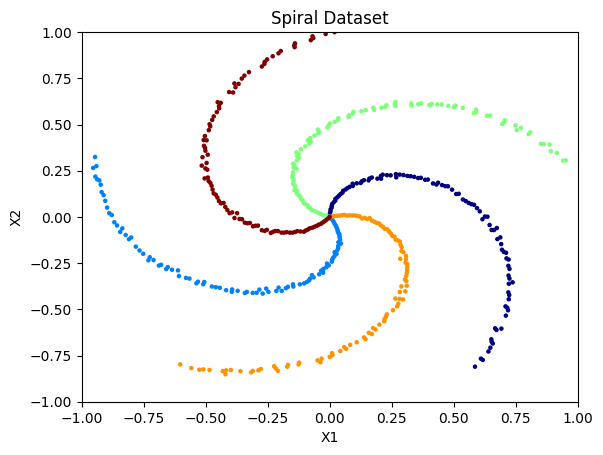

In [1]:
%load_ext autoreload
%autoreload 2

# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Function to generate the spiral dataset
def generate_spiral_data(n_points, n_spirals, noise=0.02):
    X = np.zeros((n_points * n_spirals, 2))
    y = np.zeros(n_points * n_spirals, dtype=int)
    delta_theta = 4 * np.pi / n_spirals
    for i in range(n_spirals):
        theta = np.linspace(i * delta_theta, (i + 1) * delta_theta, n_points)
        r = np.linspace(0.0, 1, n_points)
        t = theta + np.random.randn(n_points) * noise
        X[i * n_points:(i + 1) * n_points] = np.column_stack((r * np.sin(t), r * np.cos(t)))
        y[i * n_points:(i + 1) * n_points] = i
    return X, y

# Generating the spiral dataset with 100 points and 5 spirals
n_points = 100
n_spirals = 5
X, y = generate_spiral_data(n_points, n_spirals)

# Plotting the spiral dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet', s=5)
plt.title('Spiral Dataset')
plt.xlabel('X1')
plt.ylabel('X2')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
def MLP(k=200):
    return nn.Sequential(
                nn.Linear(2, k), nn.SiLU(),
                nn.Linear(k, k), nn.SiLU(),
                nn.Linear(k, n_spirals))
                

First lets train using 1000 epochs of SGD and Adam for comparison

In [3]:
learning_rate = 1e-2
epochs = 500

model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
adam_losses = []
for epoch in range(epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    adam_losses.append(loss.item())
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')


Epoch [100/500], Loss: 0.034053195267915726
Epoch [200/500], Loss: 0.023403983563184738
Epoch [300/500], Loss: 0.020406672731041908
Epoch [400/500], Loss: 0.01879812590777874
Epoch [500/500], Loss: 0.01795177347958088


Now lets make a 2nd order method using cola, here we will use the Gauss-Newton approximation to the Hessian as well the PSD Fisher matrix.

First let's make it so we can call as an explicit function of it's parameters (like in jax).

In [5]:
import torch.func as tf

def flatten_params(params):
    shapes = [p.shape for p in params]
    flat_params = torch.cat([p.flatten() for p in params])
    return flat_params, shapes


def unflatten_params(flat_params, shapes):
    params = []
    i = 0
    for shape in shapes:
        size = torch.prod(torch.tensor(shape)).item()
        param = flat_params[i:i + size]
        param = param.view(shape)
        params.append(param)
        i += size
    return params

model = MLP()
flat_p, shape = flatten_params(list(model.parameters()))
flat_p = flat_p.detach().requires_grad_(True)

def stateless_model(flatparams, x):
    params = unflatten_params(flatparams, shape)
    names = list(n for n, _ in model.named_parameters())
    nps = {n: p for n, p in zip(names, params)}
    return tf.functional_call(model, nps, x)

Now let's construct the Gauss Newton matrix to use as a PSD proxy for the Hessian in Newtons method.

$G = \sum_i J(x_i)^THJ(x_i)$ where $J\in \mathbb{R}^{C \times p}$ is the Jacobian of the network for a single data point, $p$ is the number of parameters and $C$ is the number of outputs (classes).
Here $H$ is the Hessian of the loss function with respect to the logits.

Alternatively, we might consider Natural gradient descent (using the Fisher information matrix $F$).

Here we will annotate the matrices as PSD so as to enable more efficient inversion methods, and we will add a small amount of Tikhonov regularization to the diagonal to improve the conditioning.

In [6]:
import cola

def flat_fn(p):
    return stateless_model(p, X).reshape(-1)

def GN(p):
    """Gauss-Newton approximation to the Hessian"""
    J = cola.ops.Jacobian(flat_fn, p)
    loss = lambda z: criterion(z.reshape(X.shape[0],-1),y)*n_spirals
    H = cola.ops.Hessian(loss, flat_fn(p))
    G = J.T @ H @ J
    return cola.PSD(G+1e-3*cola.ops.I_like(G))

def Fisher(p):
    F = cola.ops.FIM(lambda p: stateless_model(p, X), p)
    return cola.PSD(F+1e-3*cola.ops.I_like(F))

def flat_loss(params):
    return criterion(flat_fn(params).reshape(X.shape[0],-1), y)

We can check the eigenvalues of GN and F to make sure they are not too big. Note that these matrices are already very big (40k x 40k), already far too large to use a dense method.

In [7]:
print(GN(flat_p).shape)

(41805, 41805)


In [8]:
with torch.no_grad():
    print(f"GN eigmax: {cola.linalg.eigmax(GN(flat_p), tol=1e-2)}")
    print(f"Fisher eigmax: {cola.linalg.eigmax(Fisher(flat_p), tol=1e-2)}")

AttributeError: module 'cola.linalg' has no attribute 'eigmax'

Below we implement the optimization loop in this stateless manner.

We limit the tolerance and max iterations of the (iterative) solves so as to reduce the computation time. Though we don't do so here, adding a preconditioner (e.g. Jacobi, PivotedCholesky, Nystrom) would substantially accelerate the convergence of the solves.
Let's compare the two second order methods:

In [9]:
from cola import Auto, CG
# Method 1: Hessian weighted Gauss Newton
p = flat_p.clone()

gnh_losses = []
for epoch in range(epochs//5):
    with torch.no_grad(): # don't pay extra memory for recording the computation graph
        g = torch.func.grad(flat_loss)(p)
        p -= cola.inv(GN(p),alg=Auto(tol=1e-3, max_iters=20)) @ g
        loss = flat_loss(p)
        gnh_losses.append(loss.item())
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')

Epoch [10/500], Loss: 0.27291446924209595
Epoch [20/500], Loss: 0.0754242092370987
Epoch [30/500], Loss: 0.031930822879076004
Epoch [40/500], Loss: 0.020879896357655525
Epoch [50/500], Loss: 0.017709802836179733
Epoch [60/500], Loss: 0.0167816374450922
Epoch [70/500], Loss: 0.016456445679068565
Epoch [80/500], Loss: 0.01631750538945198
Epoch [90/500], Loss: 0.016247177496552467
Epoch [100/500], Loss: 0.016206851229071617


In [15]:
# Method 2: Natural gradient descent
p = flat_p.clone()

natural_gradient_losses = []
for epoch in range(epochs//5):
    with torch.no_grad(): # don't pay extra memory for recording the computation graph
        g = torch.func.grad(flat_loss)(p)
        p -= .5*cola.inv(Fisher(p),alg=Auto(tol=1e-3, max_iters=20)) @ g

        loss = flat_loss(p)
        natural_gradient_losses.append(loss.item())
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')

Epoch [10/500], Loss: 0.09792637825012207
Epoch [20/500], Loss: 0.02344960719347
Epoch [30/500], Loss: 0.01818729005753994
Epoch [40/500], Loss: 0.017070483416318893
Epoch [50/500], Loss: 0.016666045412421227
Epoch [60/500], Loss: 0.016476090997457504
Epoch [70/500], Loss: 0.01637142337858677
Epoch [80/500], Loss: 0.01630719192326069
Epoch [90/500], Loss: 0.01626463606953621
Epoch [100/500], Loss: 0.016234802082180977


Performing solves with these matrices for the 2nd order methods, we see that the optimization converges much faster per iteration than Adam.

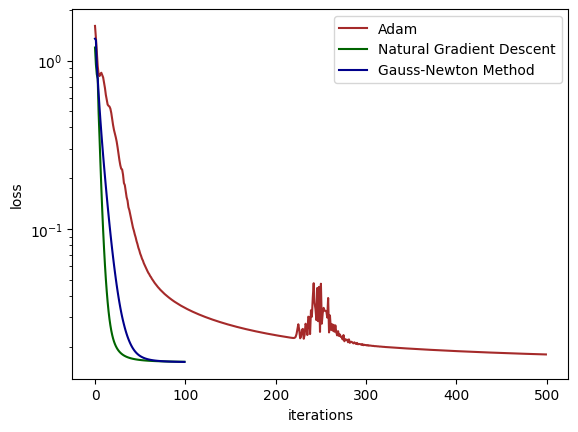

In [16]:
plt.plot(adam_losses, label='Adam', color='brown')
plt.plot(natural_gradient_losses, label='Natural Gradient Descent', color='darkgreen')
plt.plot(gnh_losses, label='Gauss-Newton Method', color='darkblue')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()

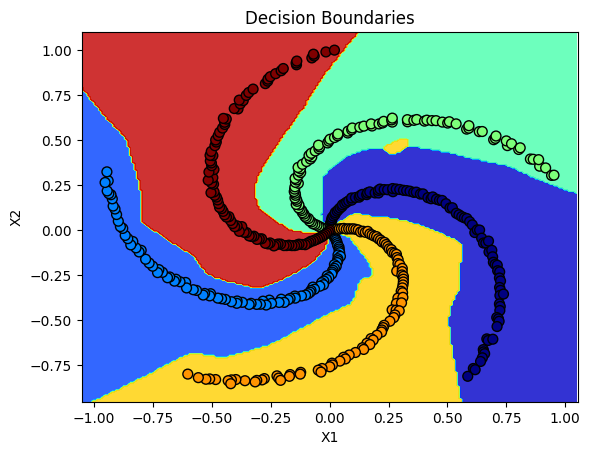

In [18]:
def plot_decision_boundary(model, X, y):
    # Creating a mesh grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predicting the class labels for the mesh grid
    Z = stateless_model(p, torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
    Z = torch.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)

    # Plotting the decision boundaries
    plt.contourf(xx, yy, Z.detach().numpy(), alpha=0.8, cmap='jet')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50, linewidth=1, cmap='jet')
    plt.xlim(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    plt.ylim(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)
    plt.title('Decision Boundaries')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

# Plotting the decision boundaries
from functools import partial
plot_decision_boundary(partial(stateless_model,p), X, y)

In [1]:
from plum import dispatch
import logging
logging.getLogger().setLevel(logging.INFO)

In [2]:
@dispatch(cond = lambda a: a>0)
def test(a: int):
    return -a

@dispatch
def test(a: str):
    return a

@dispatch
def test(a):
    return a
    

In [3]:
test("a")

INFO:root:Dispatched on test(str)


'a'

In [4]:
test.methods

[Signature(int, implementation=<function test at 0x7f68c4491ab0>),
 Signature(str, implementation=<function test at 0x7f68c4491a20>),
 Signature(typing.Any, implementation=<function test at 0x7f68c4491b40>)]

In [5]:
test._resolved

[(<function __main__.test(a: int)>,
  None,
  <function __main__.<lambda>(a)>,
  0,
  False),
 (<function __main__.test(a: str)>, None, None, 0, False),
 (<function __main__.test(a)>, None, None, 0, False)]

In [6]:
with test.disable_methods((str,)):
    test(2)
    test("a")
    test("b")
    logging.warning(test(-2))
    logging.warning(test(22))

INFO:root:Dispatched on test(int) with cond=<lambda>
INFO:root:Dispatched on test(typing.Any)
INFO:root:Dispatched on test(typing.Any)
INFO:root:Dispatched on test(typing.Any)
INFO:root:Dispatched on test(int) with cond=<lambda>


In [7]:
test._resolved

[(<function __main__.test(a: int)>,
  None,
  <function __main__.<lambda>(a)>,
  0,
  False),
 (<function __main__.test(a: str)>, None, None, 0, False),
 (<function __main__.test(a)>, None, None, 0, False),
 (<function <function test at 0x7f68c4491ab0> with 2 registered and 1 pending method(s)>,
  Signature(str),
  None,
  None,
  True)]

In [8]:
test.methods

TypeError: None is not a callable object

In [5]:
test("a")

INFO:root:Dispatched on test(str)


'a'

# Computing the eigenspectrum of the Hessian of a Neural Network

In this notebook we will consider computing the eigenvalues of the Hessian of the loss function for a ResNet18.

In [10]:
%pip install -q timm
%pip install -q detectors

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


First let's load a pretrained resnet18 model on CIFAR10 and verify that it is loaded correctly.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import detectors
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
trainset = torchvision.datasets.CIFAR10(root=os.path.expanduser('~/datasets'), train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True)
testset = torchvision.datasets.CIFAR10(root=os.path.expanduser('~/datasets'), train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False)
criterion = torch.nn.CrossEntropyLoss()

# Load pretrained ResNet18 model and verify the results
model = timm.create_model("resnet18_cifar10", pretrained=True).to(device).eval()
with torch.no_grad():
    correct = sum((model(images.to(device)).argmax(1) == labels.to(device)).sum().item() for images, labels in testloader)
accuracy = 100 * correct / len(testset)
print(f"Test accuracy: {accuracy:.2f}%")

Files already downloaded and verified
Files already downloaded and verified
Test accuracy: 94.98%


Next we will define a function that computes the loss explicitly as a function of the parameters, so we can compute the Hessian of this function.

In [2]:
import torch.func as tf
from torch.utils._pytree import tree_flatten, tree_unflatten

# make stateless model
def flatten_params(params):
    shapes = [p.shape for p in params]
    flat_params = torch.cat([p.flatten() for p in params])
    return flat_params, shapes


def unflatten_params(flat_params, shapes):
    params = []
    i = 0
    for shape in shapes:
        size = torch.prod(torch.tensor(shape)).item()
        params.append(flat_params[i:i + size].view(shape))
        i += size
    return params

flat_p, shape = flatten_params(list(model.parameters()))
flat_p = flat_p.detach().requires_grad_(True)

def stateless_model(flatparams, x):
    params = unflatten_params(flatparams, shape)
    names = list(n for n, _ in model.named_parameters())
    nps = {n: p for n, p in zip(names, params)}
    return tf.functional_call(model, nps, x)

def flat_loss(X,y,params):
    return criterion(stateless_model(params, X).reshape(X.shape[0],-1), y)

Now we will define the Hessian of this loss function. Due to memory constraints we cannot compute the loss for the entire dataset simultaneously, so instead we need to loop over the elements in the dataloader. For this we will create a new linear operator `BatchedHessian`

In [3]:
import cola
from functools import partial

class BatchedHessian(cola.ops.LinearOperator):
    def __init__(self, loss, params, dataloader):
        self.loss = loss
        self.params = params
        self.dataloader = dataloader
        super().__init__(dtype=params.dtype, shape=(params.numel(), params.numel()),
                        annotations={cola.SelfAdjoint}) # mark it as self-adjoint

    def _matmat(self, V):
        HV = torch.zeros_like(V)
        with torch.no_grad():
            n = 0
            for X,y in self.dataloader:
                with torch.enable_grad():
                    H = cola.ops.Hessian(partial(self.loss, X.to(self.device), y.to(self.device)), self.params)
                    out = H@V
                    n +=1
                HV += out
        return HV/n

In [4]:
H = BatchedHessian(flat_loss, flat_p, testloader)

As we can see, the matrix is of considerable size because of the 10M+ parameters of the model.

In [6]:
print(f"size of Hessian: {H.shape}")

size of Hessian: (11173962, 11173962)


Now we will use Lanczos to compute an approximation to the Hessian eigenvalues. Setting the maximum iterations to $30$ in order for the computation to only take ~15 minutes, but with more time we can get more eigenvalues.

In [7]:
eigs, eigvecs = cola.eig(H, max_iters=30, tol=1e-5, pbar=True)

Running body_fun:   0%|          | 0/100 [00:00<?, ?it/s]

In this case we have computed the ritz values, which are good approximations for the eigenvalues for the largest and smallest magnitude eigenvalues. We can see the spectrum below.

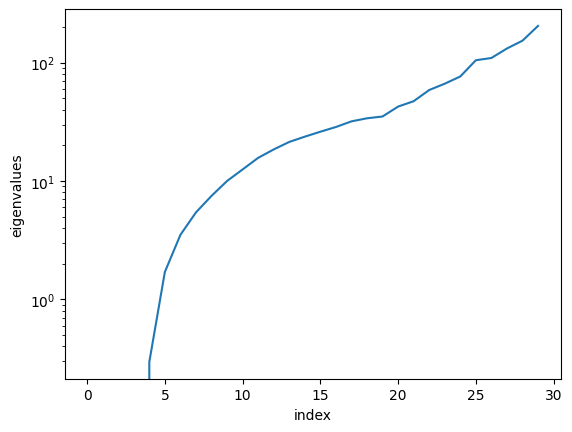

In [ ]:
import matplotlib.pyplot as plt
plt.plot(eigs.cpu().data.numpy()/200)
plt.yscale('log')
plt.ylabel('eigenvalues')
plt.xlabel('index')
plt.show()

# jit, vmap, grad, and pytrees

All `LinearOperator` objects are native jax and pytorch pytrees.

This means that we can vmap over them, jit functions with them, as well as other operations.

## Example: Tree Map



## Jit example (in jax)

Let's choose jitting a function involving matrix square roots.

In [1]:
from jax import jit
import numpy as np
import jax.numpy as jnp
import jax.config as config
# set cpu
config.update("jax_platform_name", "cpu")
import cola

# construct a linear operator
A = jnp.array(np.random.randn(2, 2))
B = cola.SelfAdjoint(cola.lazify(A.T@A+ 1e-4*jnp.eye(2)))
D = cola.SelfAdjoint(cola.diag(jnp.array([3.,0.2, 1.])))
K = cola.kron(B,D)

Lets verify that CoLA indeed computes the sqrts on this matrix

In [2]:
v = jnp.array(np.random.randn(6))
K_half_v = cola.sqrt(K, tol=1e-4)@v
Kv = cola.sqrt(K, tol=1e-4)@K_half_v
print("error:",jnp.linalg.norm(Kv - K@v))

/home/marc_f/anaconda3/envs/cola/lib/python3.10/site-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Callable deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


error: 3.7252903e-09


Now let's jit a function with a `LinearOperator` as an argument

In [3]:
@jit
def sqrt_mvm(K, v):
    return cola.sqrt(K, tol=1e-4)@v

print(sqrt_mvm(K,v))
print(sqrt_mvm(4*K,v)/2)

[ 0.01154765 -0.10519305  0.08695581  0.12265506  0.49678737 -0.61266834]
[ 0.01154772 -0.10519368  0.08695581  0.12265505  0.49678725 -0.61266834]


## Batched LinearOperator operations using vmap (in pytorch)

Let's consider a function that constructs some linear operators, and a separate function that applies some transformations.


In [10]:
import cola
import torch
import numpy as np

def construct_complicated_linops(X):
    X = cola.lazify(X)
    Y = X@X.T
    Y = cola.PSD(Y+cola.ops.I_like(Y))
    D = cola.PSD(cola.diag(torch.linspace(0.1,1,2)))
    W = cola.ops.BlockDiag(Y,D, multiplicities=[2, 1])
    diag_W = cola.diag(W)
    return W, cola.PSD(cola.diag(diag_W))

W,diag_W = construct_complicated_linops(torch.randn(3,3))
print(W[:5,:5].to_dense())
print(diag_W[:5,:5].to_dense())

tensor([[1.8414, 0.6225, 0.8826, 0.0000, 0.0000],
        [0.6225, 2.4913, 1.5865, 0.0000, 0.0000],
        [0.8826, 1.5865, 3.7751, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.8414, 0.6225],
        [0.0000, 0.0000, 0.0000, 0.6225, 2.4913]])
tensor([[1.8414, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 2.4913, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 3.7751, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.8414, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.4913]])


For the example, let's consider a function that uses the diagonal of `W` as a symmetric preconditioner, used explicitly (rather than supplied as an argument to inverse).

In [11]:
def perform_operations(W,D,v):
    P = cola.pow(D, -0.5) # D^{-1/2}
    y = P@cola.inv(P@W@P,tol=1e-4)@P@v
    return y 

Now suppose that we want to perform this operation over a batch of LinearOperators, each with different data.

First we can vmap over the functions constructing the LinearOperators:

In [24]:
from torch.func import vmap
bW, bD = vmap(construct_complicated_linops)(torch.randn(3,5, 5))

Notice that the objects are the same types and shapes,

In [25]:
print(bW.shape, type(bW))
print(bD.shape, type(bD))

(12, 12) <class 'cola.ops.operators.BlockDiag[cola.ops.operators.Sum[cola.ops.operators.Product[cola.ops.operators.Dense, cola.ops.operators.Transpose[cola.ops.operators.Dense]], cola.ops.operators.Identity], cola.ops.operators.Diagonal]'>
(12, 12) <class 'cola.ops.operators.Diagonal'>


However the data the makes up these objects now has a batch dimension:

In [26]:
bD.diag.shape

torch.Size([3, 12])

In general these objects should not be used except precisely in conjunction with a function which is vmapped over a LinearOperator input, as shown below with perform_operations.

In [27]:
all_outs = torch.func.vmap(perform_operations)(bW, bD, torch.randn(3,bW.shape[0]))
print(all_outs.shape)

torch.Size([3, 12])


🚧 Note: Not all LinearOperators with pytorch backend support vmap 🚧

For example kronecker:

In [29]:
def get_entries(M):
    return M[:5,:5].to_dense()

try:
    vmap(get_entries)(vmap(cola.kron)(bW, bD))
except RuntimeError as e:
    print("raised exception:", e)

raised exception: Batching rule not implemented for aten::moveaxis.int; the fallback path doesn't work on out= or view ops.


## Gradients and PyTrees (jax example)